# Technology focus: Xenium

This notebook will present an overview of the plotting functionalities of the `spatialdata` framework, in the context of a Xenium dataset.

Other notebooks, focused on data manipualtion, are also available for Xenium data:
- Alignment of a Xenium and Visium datasets (this is one of the reproducibility notebooks for the analysis of our paper) [notebook](https://github.com/scverse/spatialdata-notebooks/blob/main/notebooks/paper_reproducibility/00_xenium_and_visium.ipynb)
- Workflow showing saving annotations in Xenium Explorer and accessing them in SpaitalData, and viceversa [notebook](https://github.com/quentinblampey/spatialdata_xenium_explorer/blob/master/docs/10x_tutorials/xenium/xenium_tuto.ipynb). Tutorial from Quentin Blampey.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

## Loading the data

A reader for Xenium data is available in `spatialdata-io`. We used it to parse and convert to Zarr a [Xenium dataset of Human Lung Cancer](https://www.10xgenomics.com/datasets/preview-data-ffpe-human-lung-cancer-with-xenium-multimodal-cell-segmentation-1-standard).

You can download the data from the link above, or from this [convenience python script](https://github.com/giovp/spatialdata-sandbox/blob/main/xenium_2.0.0_io/download.py) and convert it to spatialdata format with [this script](https://github.com/giovp/spatialdata-sandbox/blob/main/xenium_2.0.0_io/to_zarr.py), rename the `.zarr` store to `xenium.zarr` and place it in the current folder (in alternatively you can use symlinks to make the data visible).

The dataset used in this notebook is the latest Xenium Multimodal Cell Segmentation extension of the Xenium technology, available for data processed using Xenium Analyzer version 2.0.0 and when Cell Segmentation Kit was used. Nevertheless, the `xenium()` reader supports all the Xenium versions.

In [2]:
xenium_path = "./xenium_2.0.0.zarr"

In [3]:
%%time
import spatialdata as sd
import spatialdata_plot  # noqa: F401

sdata = sd.read_zarr(xenium_path)
sdata

/opt/miniconda3/envs/ome/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/ome/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


CPU times: user 2.34 s, sys: 448 ms, total: 2.79 s
Wall time: 3.2 s


SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-data-converter/dependencies/spatialdata-sandbox/xenium_2.0.0_io/data.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 45087, 11580), (3, 22543, 5790), (3, 11271, 2895), (3, 5635, 1447), (3, 2817, 723)
│     └── 'morphology_focus': DataTree[cyx] (4, 17098, 51187), (4, 8549, 25593), (4, 4274, 12796), (4, 2137, 6398), (4, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
  

The datasets contains 2 large microscopy image, represented as a multiscale, chunked image; the first one, `he_image` is the H&E image of the tissue, stained post-Xenium measurement, and the `morphology_focus` image which consists of the image of the tissue used for the Xenium experiment.

Furthermore, it also contains label images, that are the segmentation masks of cells or nuclei (`cell_labels` and `nucleus_labels` respectively).

## Plotting the images

Let's visualize the images.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Your image has 4 channels. Sampling categorical colors and using multichannel strategy 'stack' to render. 


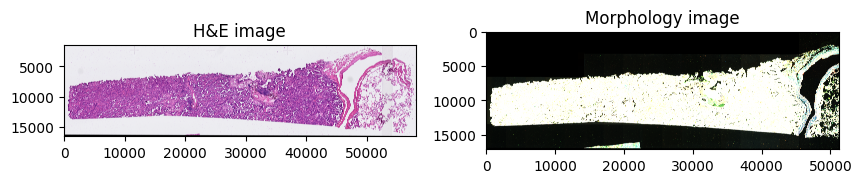

In [4]:
import matplotlib.pyplot as plt

axes = plt.subplots(1, 2, figsize=(10, 10))[1].flatten()
sdata.pl.render_images("he_image").pl.show(ax=axes[0], title="H&E image")
sdata.pl.render_images("morphology_focus").pl.show(ax=axes[1], title="Morphology image")

We can also crop and visualize a smaller region to appreciate morphological differences measured by the two modalities, together with the cell segmentation mask. Spatial cropping is introduced in a dedicated notebook in the documentation.

/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData

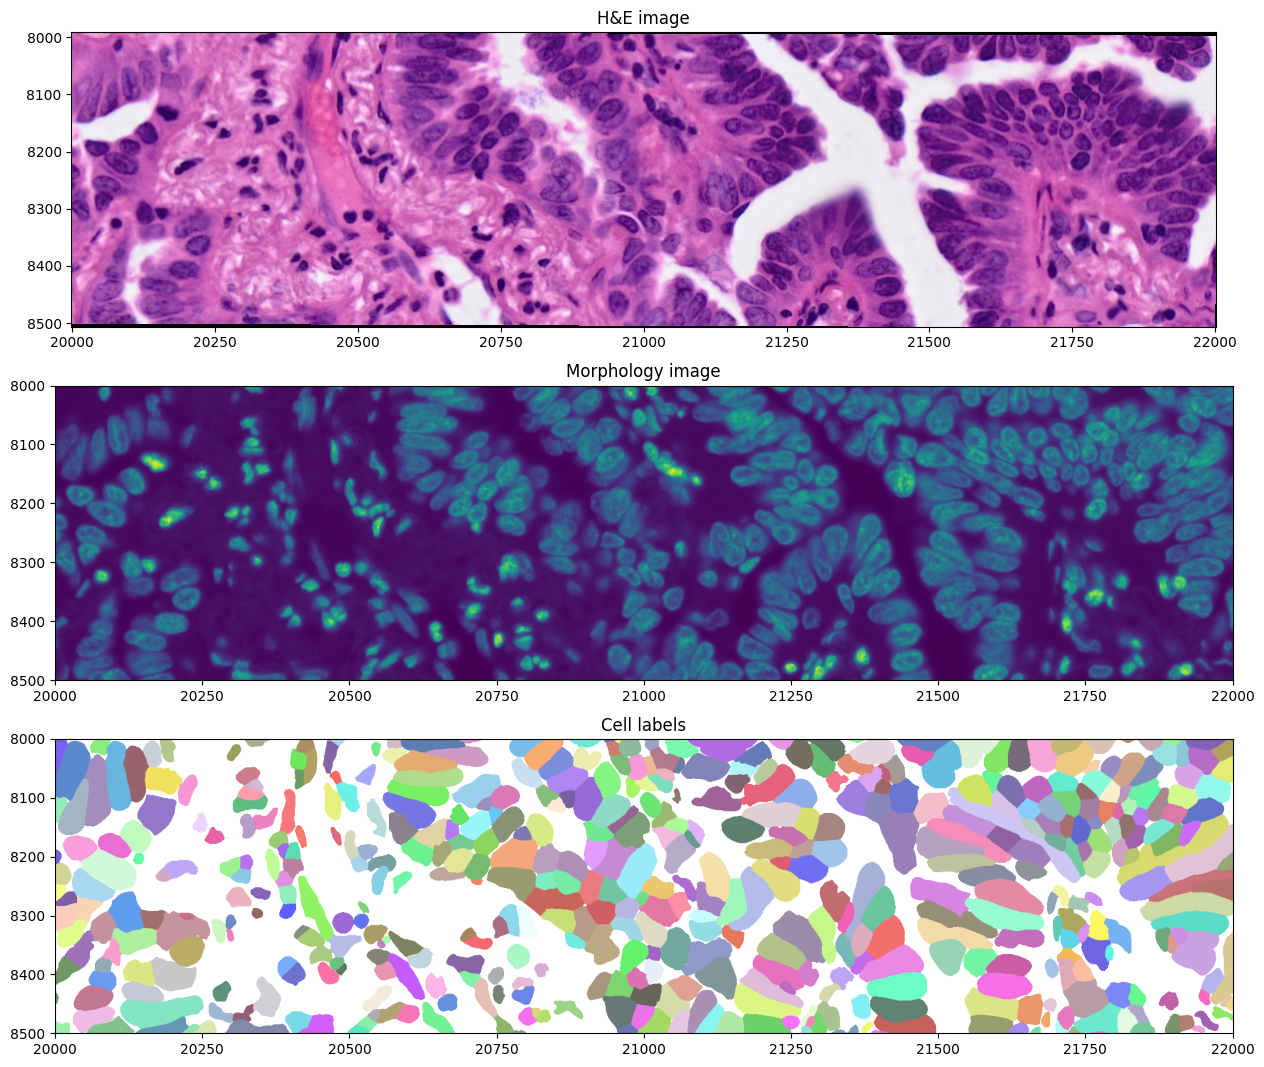

In [5]:
from spatialdata import bounding_box_query

axes = plt.subplots(3, 1, figsize=(20, 13))[1].flatten()


def crop0(x):
    return bounding_box_query(
        x,
        min_coordinate=[20_000, 8000],
        max_coordinate=[22_000, 8500],
        axes=("x", "y"),
        target_coordinate_system="global",
    )


crop0(sdata).pl.render_images("he_image").pl.show(
    ax=axes[0], title="H&E image", coordinate_systems="global"
)
crop0(sdata).pl.render_images("morphology_focus", channel="DAPI").pl.show(
    ax=axes[1], title="Morphology image", coordinate_systems="global", colorbar=False
)
crop0(sdata).pl.render_labels("cell_labels").pl.show(
    ax=axes[2], title="Cell labels", coordinate_systems="global"
)

## Exploring the multimodal segmentation

Let's visualize the 4 channels that are used, for this dataset, for computing the cell segmentation. This is specific for datasets profiled using the Cell Segmentation Kit and processed with the Xenium Analyzer >= 2.0.0.

In [6]:
from spatialdata.models import get_channel_names

channel_names = get_channel_names(sdata["morphology_focus"])
channel_names

['DAPI', 'ATP1A1/CD45/E-Cadherin', '18S', 'AlphaSMA/Vimentin']

/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData

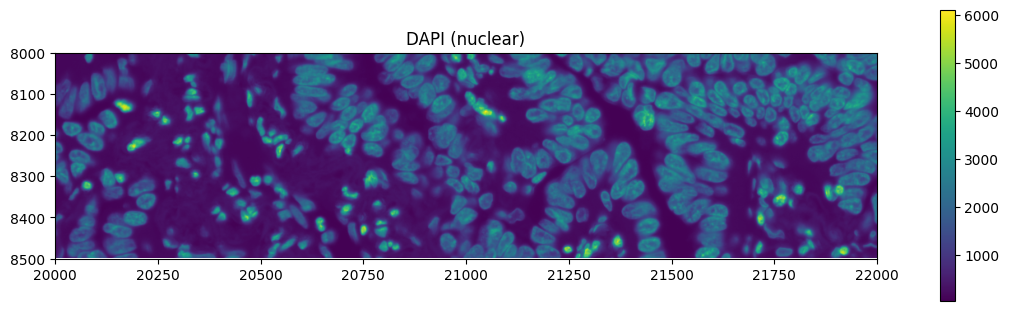

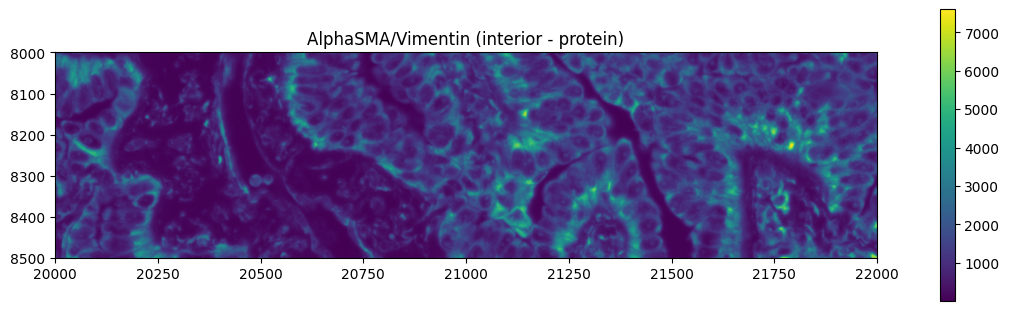

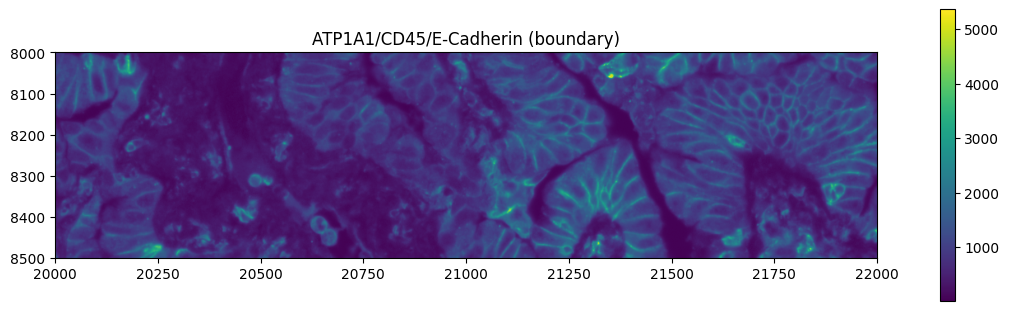

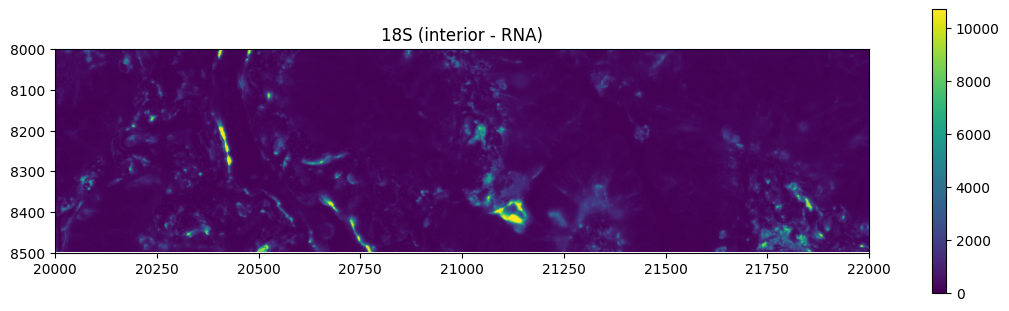

In [7]:
crop0(sdata).pl.render_images("morphology_focus", channel=channel_names[0]).pl.show(
    title="DAPI (nuclear)", figsize=(10, 3)
)
crop0(sdata).pl.render_images("morphology_focus", channel=channel_names[1]).pl.show(
    title="AlphaSMA/Vimentin (interior - protein)", figsize=(10, 3)
)
crop0(sdata).pl.render_images("morphology_focus", channel=channel_names[2]).pl.show(
    title="ATP1A1/CD45/E-Cadherin (boundary)", figsize=(10, 3)
)
crop0(sdata).pl.render_images("morphology_focus", channel=channel_names[3]).pl.show(
    title="18S (interior - RNA)", figsize=(10, 3)
)

## Plotting the gene expression data

With SpatialData we can also plot gene expression data on top of the images. We can plot the expression of a single gene, or the expression of multiple genes.
To showcase different functionalities, we will use the `cell_circles` Shapes element to overlay gene expression over the image, instead of the raster labels showed above.

Let's first normalize and select highly variable genes.

In [8]:
import scanpy as sc

sc.pp.normalize_total(sdata.tables["table"])
sc.pp.log1p(sdata.tables["table"])
sc.pp.highly_variable_genes(sdata.tables["table"])
sdata.tables["table"].var.sort_values("means")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/ome/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


gene_ids    feature_types   genome  highly_variable     means  \
UMOD    ENSG00000169344  Gene Expression  Unknown            False  0.000855   
LY6D    ENSG00000167656  Gene Expression  Unknown            False  0.001364   
SST     ENSG00000157005  Gene Expression  Unknown            False  0.001424   
TCF15   ENSG00000125878  Gene Expression  Unknown            False  0.001587   
CCL27   ENSG00000213927  Gene Expression  Unknown            False  0.001663   
...                 ...              ...      ...              ...       ...   
CAPN8   ENSG00000203697  Gene Expression  Unknown             True  0.859493   
EPCAM   ENSG00000119888  Gene Expression  Unknown            False  0.897788   
TCIM    ENSG00000176907  Gene Expression  Unknown             True  0.948361   
CYP2B6  ENSG00000197408  Gene Expression  Unknown             True  0.989477   
MALL    ENSG00000144063  Gene Expression  Unknown             True  1.119610   

        dispersions  dispersions_norm  
UMOD       0.733388          0.142545  
LY6D       0.557849         -0.404188  
SST        0.184340         -1.567515  
TCF15      0.189523         -1.551373  
CCL27      0.526737         -0.501089  
...             ...               ...  
CAPN8      1.032884          1.000000  
EPCAM      0.938736         -0.707107  
TCIM       1.136240          0.707107  
CYP2B6     1.524039          1.000000  
MALL       1.181179          1.000000  

[377 rows x 7 columns]

/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


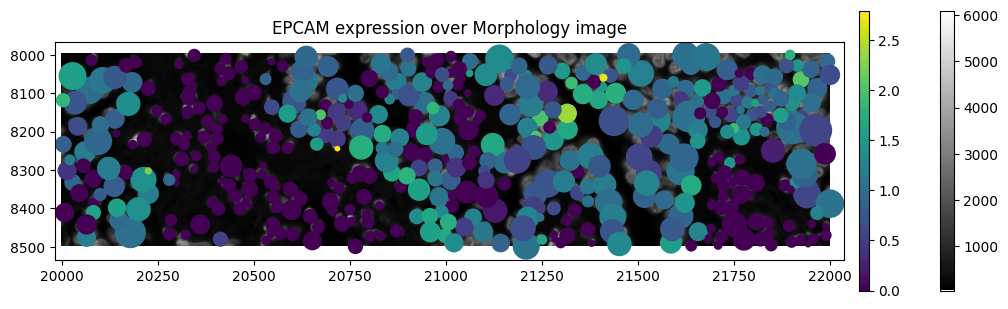

In [9]:
gene_name = "EPCAM"
crop0(sdata).pl.render_images(
    "morphology_focus", channel="DAPI", cmap="gray"
).pl.render_shapes(
    "cell_circles",
    color=gene_name,
).pl.show(
    title=f"{gene_name} expression over Morphology image",
    coordinate_systems="global",
    figsize=(10, 3),
)

We can also assign the table to a different region, in order to overlay the gene expression for the specified region.
SpatialData stores the information of which region is the table in the following places:
- in `sdata.tables[<table_name>].uns["spatialdata_attrs]["region"]` it stores the regions that the table is annotating.
- The name of the region is stored under `sdata.tables[<table_name>].obs["region_key"]`.

We can use a utility function to modify that information, and hence plot the gene expression for a different shapes.

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:482: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)
/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


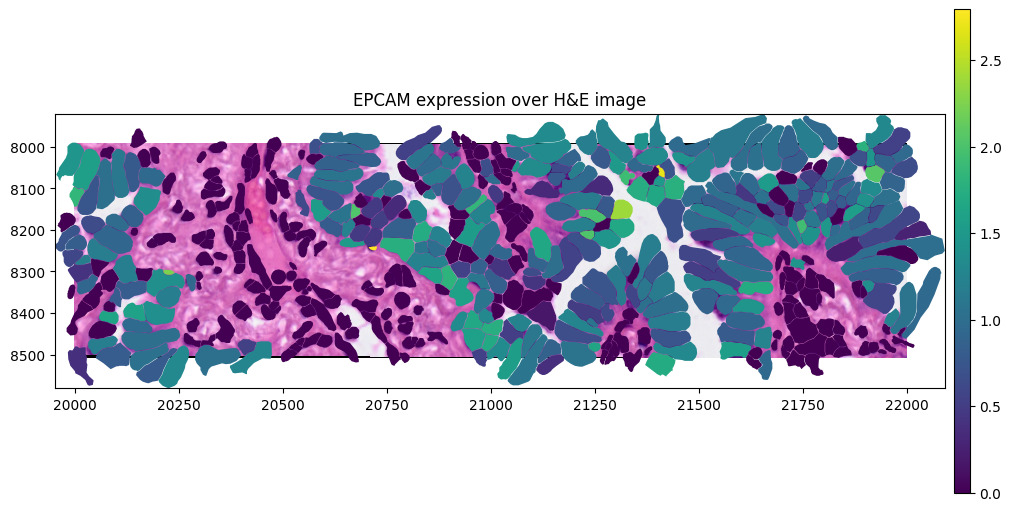

In [10]:
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

crop0(sdata).pl.render_images("he_image").pl.render_shapes(
    "cell_boundaries",
    color=gene_name,
).pl.show(
    title=f"{gene_name} expression over H&E image",
    coordinate_systems="global",
    figsize=(10, 5),
)

Finally, we can also plot transcript locations, together with the same layers selected as before.

/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     input has more than 103 categories. Uniform 'grey' color will be used for all categories.                 


/opt/miniconda3/envs/ome/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  return fn(*args_all, **kw)
/opt/miniconda3/envs/ome/lib/python3.13/functools.py:929: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/render.py:821: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = ax.scatter(


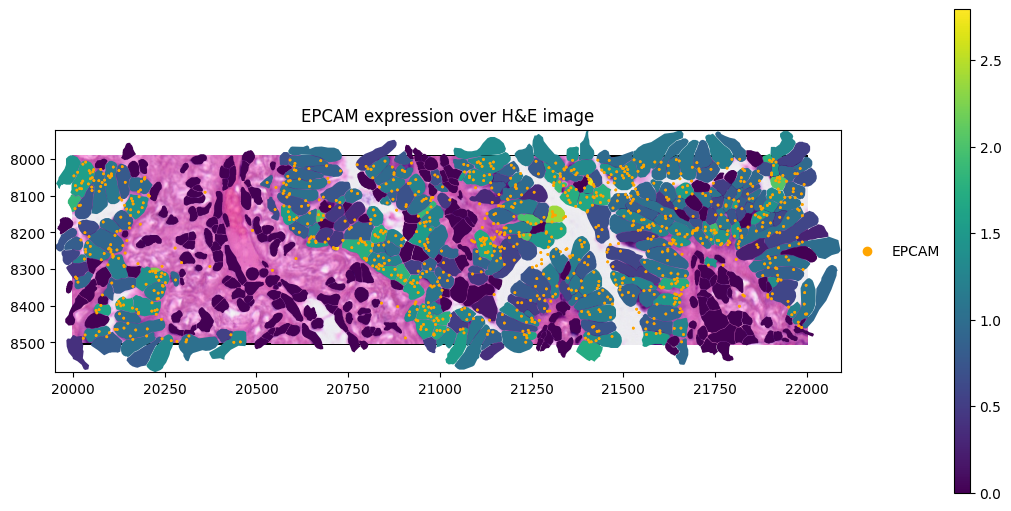

In [11]:
crop0(sdata).pl.render_images("he_image").pl.render_shapes(
    "cell_boundaries",
    color=gene_name,
).pl.render_points(
    "transcripts",
    color="feature_name",
    groups=gene_name,
    palette="orange",
).pl.show(
    title=f"{gene_name} expression over H&E image",
    coordinate_systems="global",
    figsize=(10, 5),
)